In [3]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [5]:
data_path = r"C:\Users\17813\.cache\kagglehub\datasets\nelgiriyewithana\global-weather-repository\versions\536"
print(os.listdir(data_path))  # List all files in the directory
file_path = r"C:\Users\17813\.cache\kagglehub\datasets\nelgiriyewithana\global-weather-repository\versions\536\GlobalWeatherRepository.csv"
df = pd.read_csv(file_path)
df['last_updated'] = pd.to_datetime(df['last_updated'])
df = df.sort_values('last_updated')

['GlobalWeatherRepository.csv', 'state.db']


In [7]:
# Drop redundant columns (imperial units, names, etc.)
drop_cols = ['country', 'location_name', 'timezone', 
             'temperature_fahrenheit', 'feels_like_fahrenheit', 
             'pressure_in', 'precip_in', 'visibility_miles',
             'wind_mph', 'gust_mph', 
             'sunrise', 'sunset', 'moonrise', 'moonset']

df = df.drop(columns=drop_cols)


In [8]:
# Encode categorical columns
cat_cols = ['condition_text', 'wind_direction', 'moon_phase']
for col in cat_cols:
    encoder = LabelEncoder()
    df[col] = encoder.fit_transform(df[col])

In [9]:
# Scaling numerical features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df.drop(columns=['last_updated']))  # exclude timestamp
scaled_df = pd.DataFrame(scaled_features, columns=df.drop(columns=['last_updated']).columns)


In [10]:
# Create sequences (sliding window)
def create_sequences(data, target_col, n_steps=30):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data.iloc[i-n_steps:i].values)
        y.append(data.iloc[i][target_col])
    return np.array(X), np.array(y)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            23296     
                                                                 
 dropout (Dropout)           (None, 30, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 35745 (139.63 KB)
Trainable params: 35745 (139.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100

135

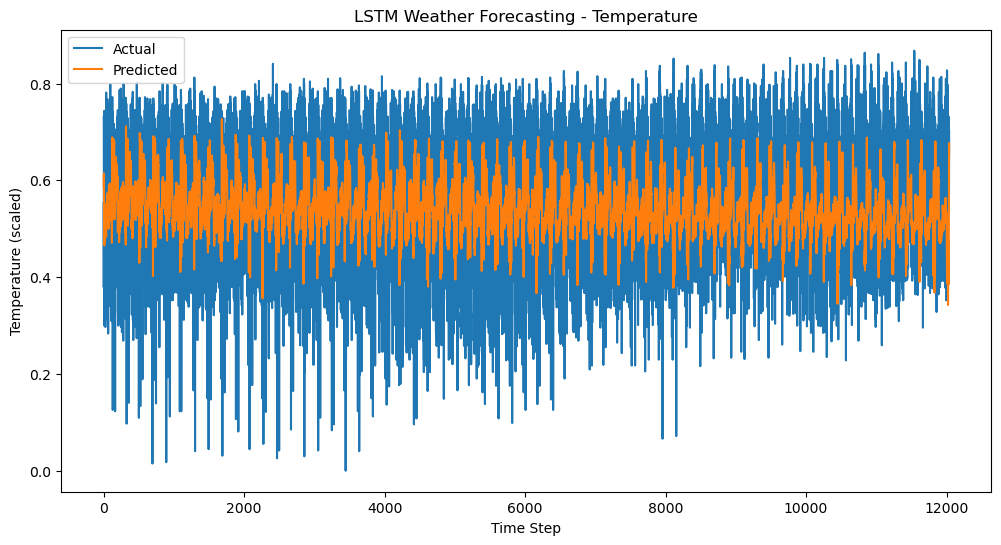

In [11]:
n_steps = 30
target_col = 'temperature_celsius'
X, y = create_sequences(scaled_df, target_col=target_col, n_steps=n_steps)

# Train/test split (80% train, 20% test)
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Build LSTM model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(n_steps, X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(1))  # Output temperature

model.compile(optimizer='adam', loss='mse')

model.summary()

# 8. Train model
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=[early_stop],
                    verbose=1)

# 9. Evaluate
y_pred = model.predict(X_test)

# Inverse transform (optional): skipped here because we predict a scaled target directly

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Test MAE: {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R2 Score: {r2:.4f}")

# 10. Plot
plt.figure(figsize=(12,6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('LSTM Weather Forecasting - Temperature')
plt.xlabel('Time Step')
plt.ylabel('Temperature (scaled)')
plt.legend()
plt.show()